In [2]:
import cv2
import mediapipe as mp
import numpy as np

In [3]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [4]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
    
    return angle 

In [5]:
import cv2
import mediapipe as mp
import numpy as np
import os
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

def calculate_angle(a, b, c):
    a = np.array(a)  # First
    b = np.array(b)  # Mid
    c = np.array(c)  # End

    radians = np.arctan2(c[1] - b[1], c[0] - b[0]) - np.arctan2(a[1] - b[1], a[0] - b[0])
    angle = np.abs(radians * 180.0 / np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle

image_dir = "C:\pukyung_202301\yolov7-object-cropping\input_video\crop\FD_In_H11H21H31_0009_20201229_14"  # Replace with the directory containing the images
output_dir = "C:\pukyung_202301\yolov7-object-cropping\input_video\crop_1"  # Replace with the directory to save the annotated images
image_files = os.listdir(image_dir)
image_files = sorted(image_files, key=lambda x: int(x.split('_')[1].split('.')[0]))

#image_files = sorted(image_files, key=lambda x: int(os.path.splitext(x)[0]))

# Setup mediapipe instance
# 신뢰도를 조절하며 그래프를 확인하기
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    angle_elbow_list = []
    angle_shoulder_list = []
    angle_hip_list = []
    angle_knee_list = []

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        print(image_path)
        frame = cv2.imread(image_path)
        

        # Recolor image to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        # Make detection
        results = pose.process(image)

        # Recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Extract landmarks
        try:
            landmarks = results.pose_landmarks.landmark

            # Get coordinates
            shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
            elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
            wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
            ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
            knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                    landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
            hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                   landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]

            # Calculate angles
            angle_elbow = calculate_angle(shoulder, elbow, wrist)
            angle_shoulder = calculate_angle(hip, shoulder, elbow)
            angle_hip = calculate_angle(knee, hip, shoulder)
            angle_knee = calculate_angle(ankle, knee, hip)

            # Append angles to the lists
            angle_elbow_list.append(angle_elbow)
            angle_shoulder_list.append(angle_shoulder)
            angle_hip_list.append(angle_hip)
            angle_knee_list.append(angle_knee)

            # Visualize angles
            cv2.putText(image, str(angle_elbow),
                        tuple(np.multiply(elbow, [image.shape[1], image.shape[0]]).astype(int)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, str(angle_shoulder),
                        tuple(np.multiply(shoulder, [image.shape[1], image.shape[0]]).astype(int)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, str(angle_hip),
                        tuple(np.multiply(hip, [image.shape[1], image.shape[0]]).astype(int)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, str(angle_knee),
                        tuple(np.multiply(knee, [image.shape[1], image.shape[0]]).astype(int)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
        except:
            pass

        # Render detections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Save annotated image
        output_file = os.path.join(output_dir, "annotated_" + image_file)
        cv2.imwrite(output_file, image)

        cv2.imshow('Pose Estimation', image)
        key = cv2.waitKey(1)  # Delay in milliseconds (2 seconds here)
        if key == ord('q'):
            break

    # Plot angle graphs
    plt.figure(figsize=(10, 6))
    plt.plot(angle_elbow_list, label='Elbow Angle')
    plt.plot(angle_shoulder_list, label='Shoulder Angle')
    plt.plot(angle_hip_list, label='Hip Angle')
    plt.plot(angle_knee_list, label='Knee Angle')
    plt.xlabel('Frame')
    plt.ylabel('Angle')
    plt.title('Angle Variation')
    plt.legend(loc=1)
    #plt.savefig('C:\pukyung_202301\yolov7-object-cropping\input_video\crop')
    plt.tight_layout()
    #plt.show()
    plt.savefig('./angle_variation')
cv2.destroyAllWindows()


FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\pukyung_202301\\yolov7-object-cropping\\input_video\\crop\\FD_In_H11H21H31_0009_20201229_14'

### 여러 이미지 폴더들에 대해 위 코드를 수행

In [1]:
import cv2
import mediapipe as mp
import numpy as np

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
output_dir = "C:\pukyung_202301\yolov7-object-cropping\input_video\crop_1"

In [3]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
    
    return angle 

90 90 90 90
90 90 90 90
105 105 105 105
87 87 87 87
86 86 86 86
86 86 86 86
89 89 89 89
90 90 90 90
30 30 30 30
90 90 90 90
29 29 29 29
76 76 76 76
90 90 90 90
116 116 116 116
90 90 90 90
24 24 24 24
89 89 89 89
90 90 90 90
89 89 89 89
90 90 90 90


C:\Users\inkwabusan\AppData\Local\Temp\ipykernel_2312\1516094673.py:100: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


73 73 73 73
53 53 53 53
91 91 91 91
83 83 83 83
61 61 61 61
137 137 137 137
118 118 118 118
90 90 90 90
90 90 90 90
90 90 90 90
90 90 90 90
90 90 90 90
90 90 90 90
58 58 58 58
89 89 89 89
90 90 90 90


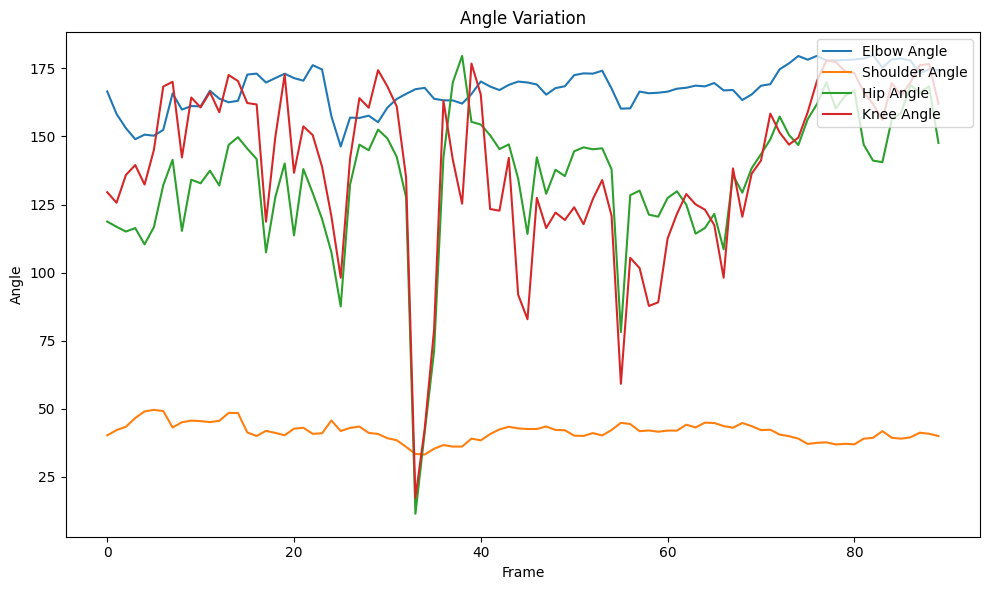

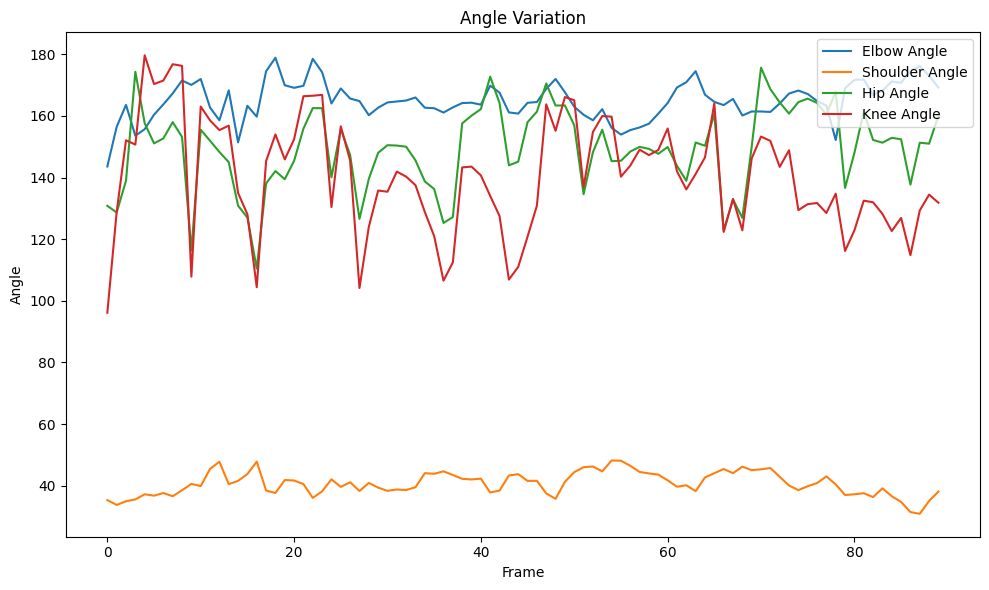

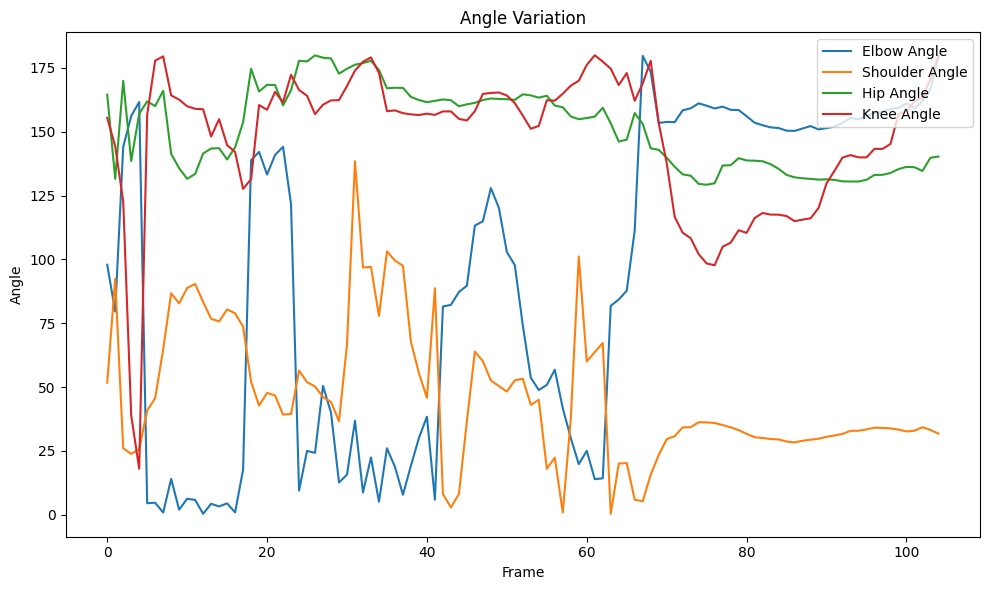

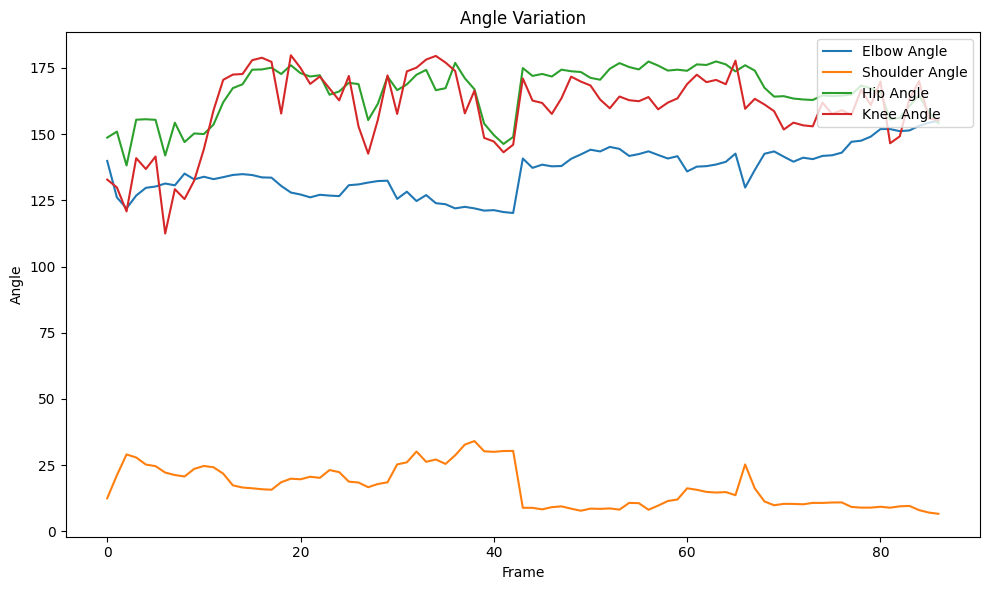

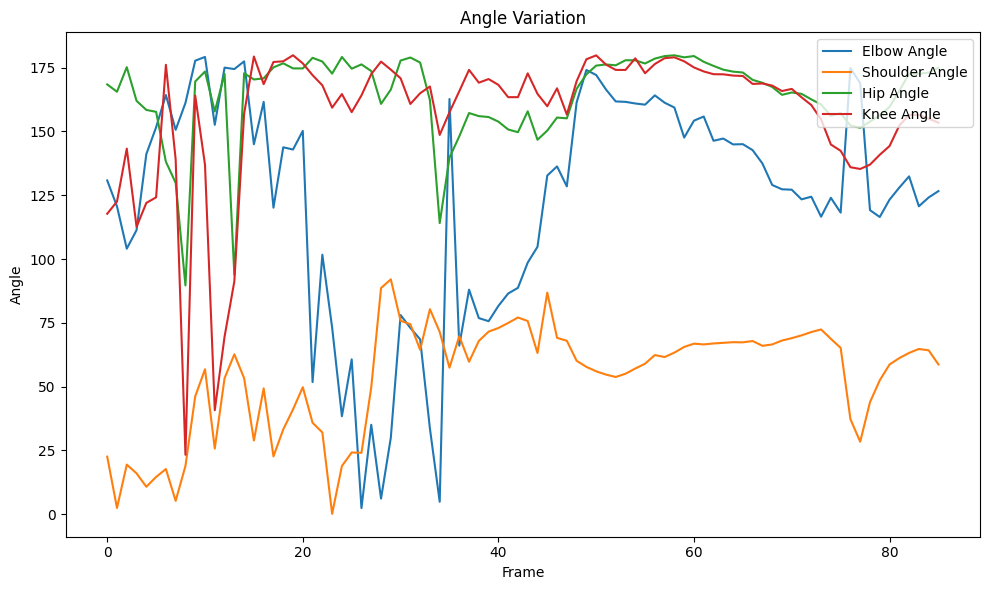

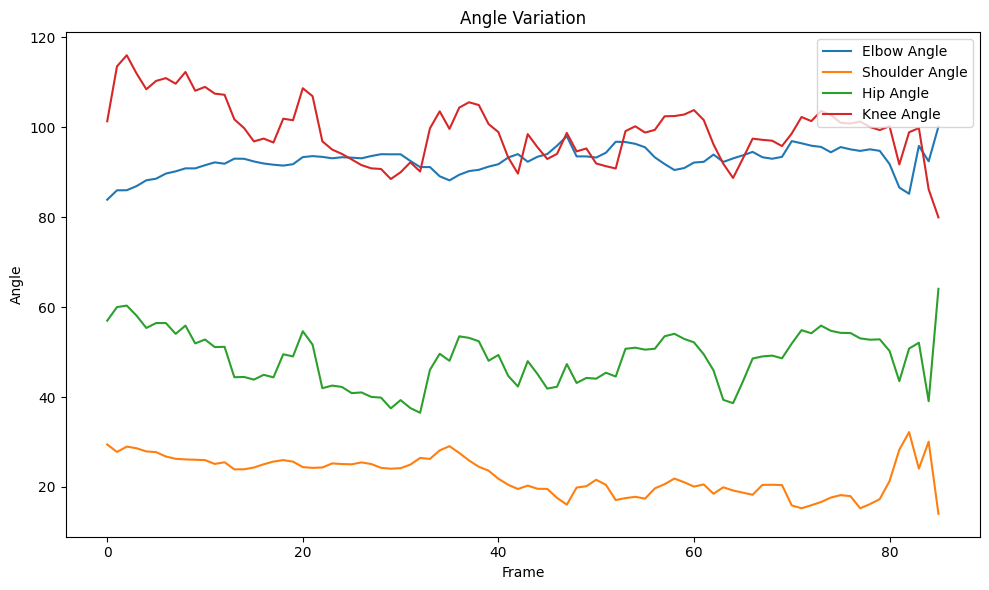

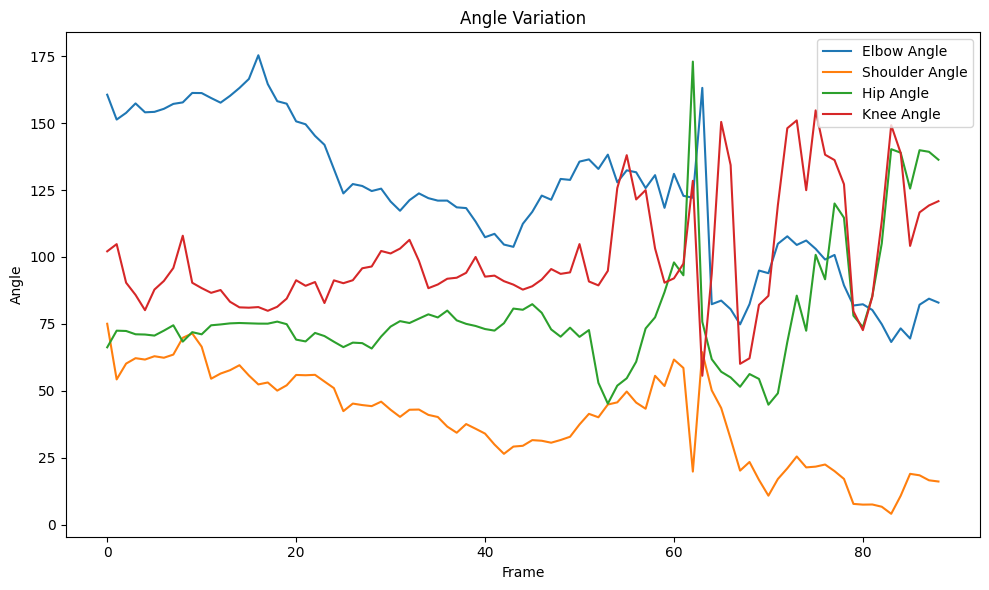

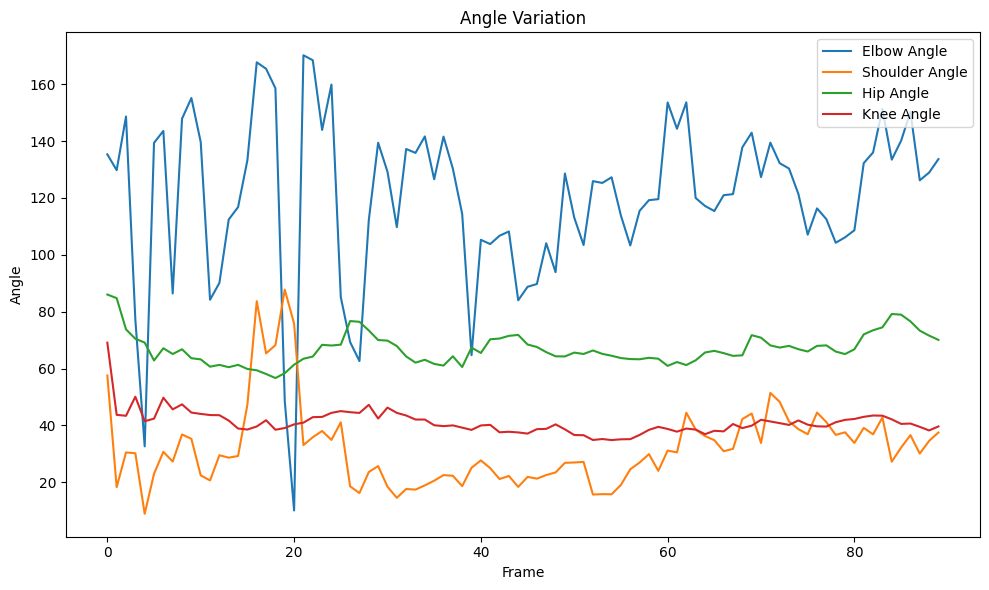

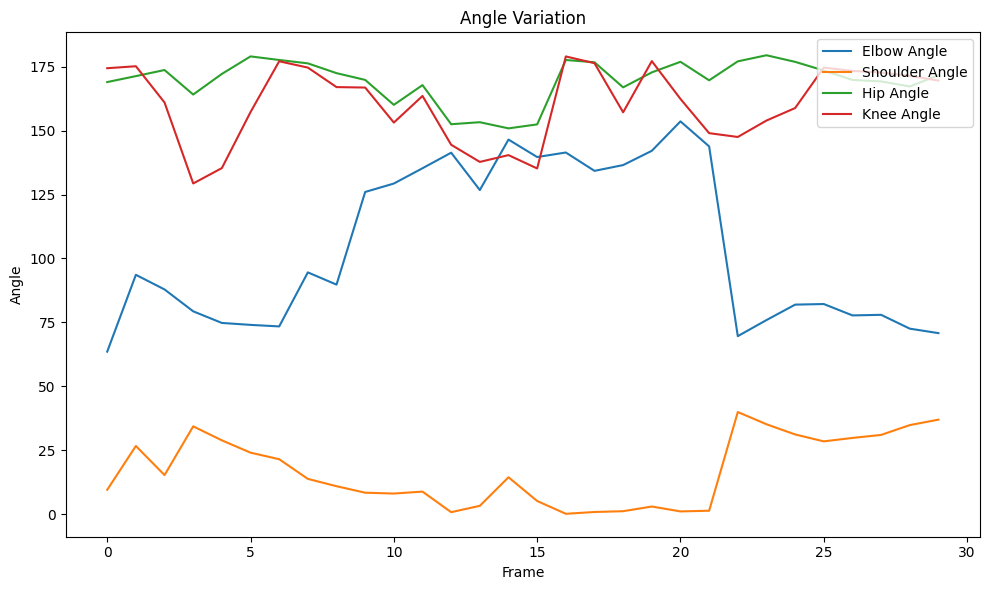

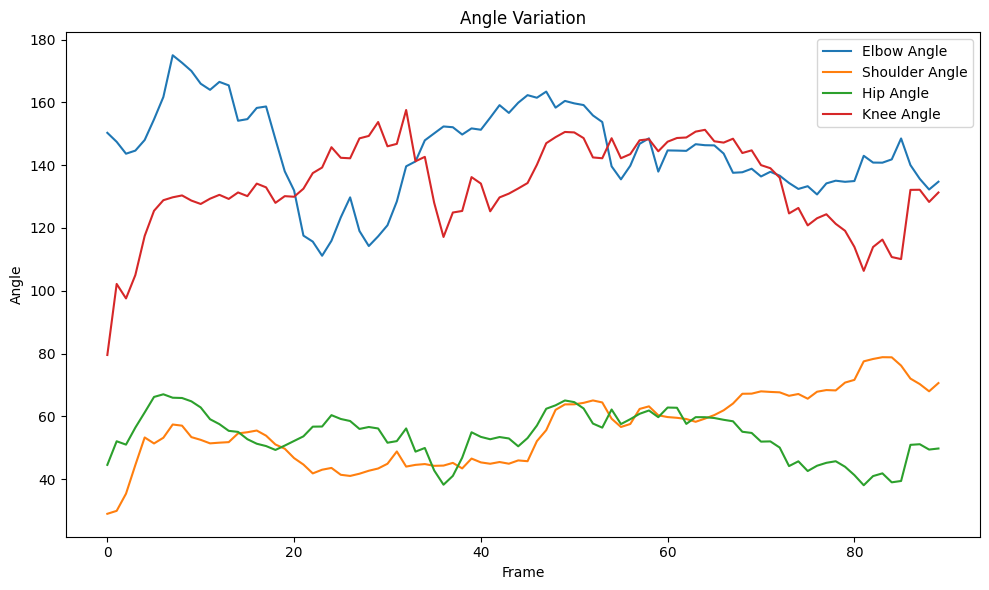

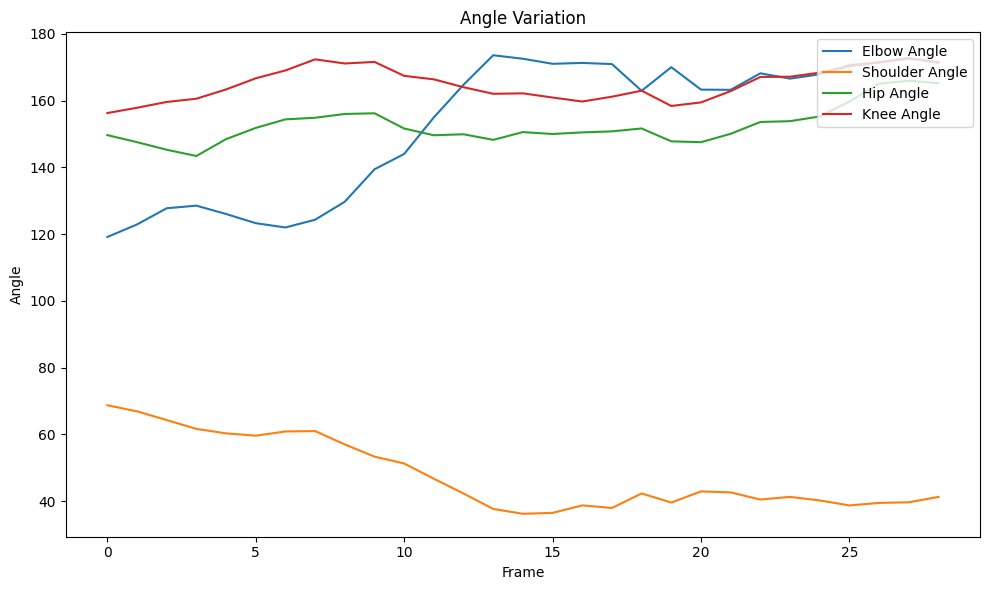

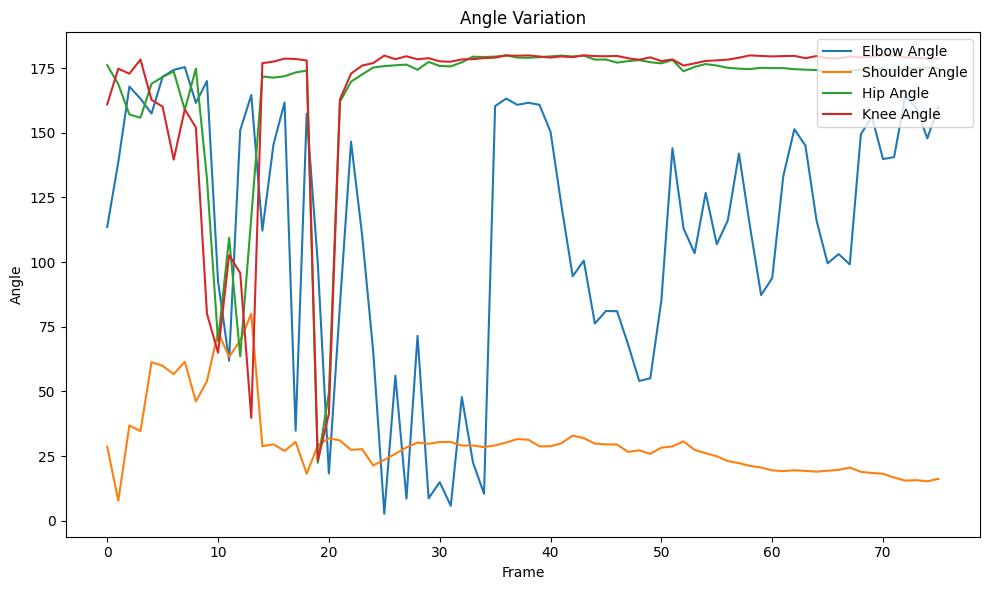

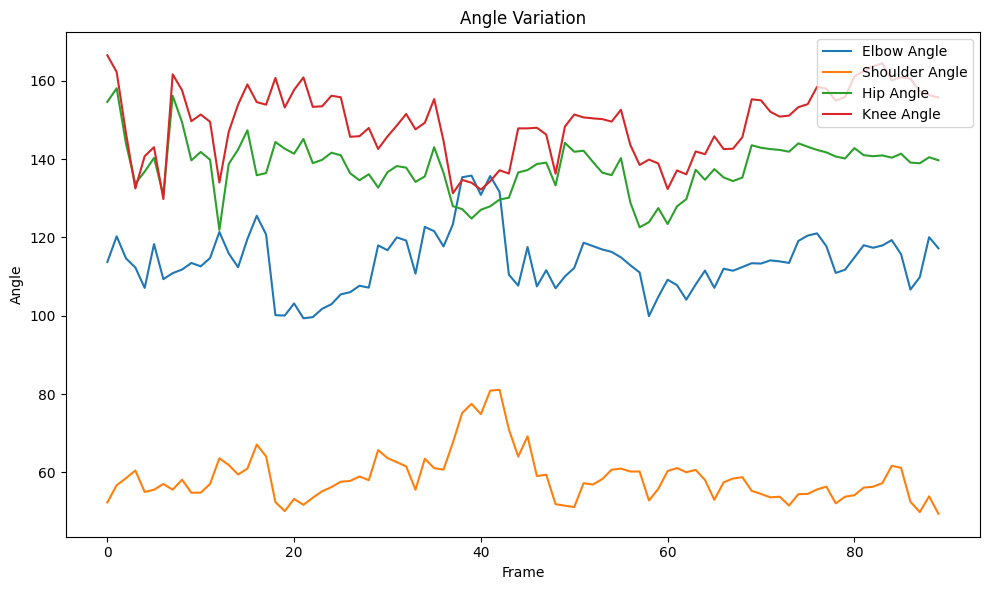

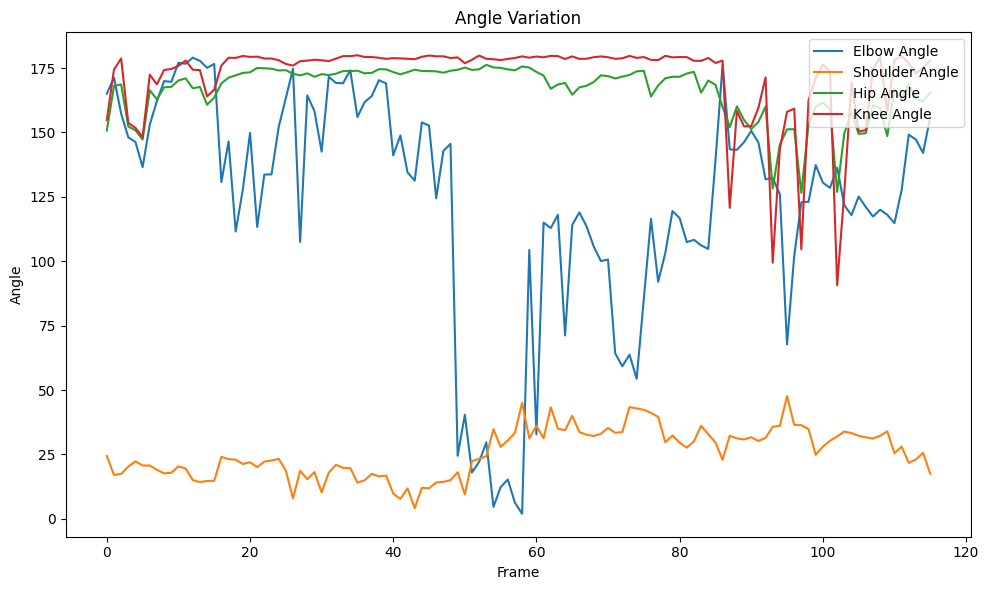

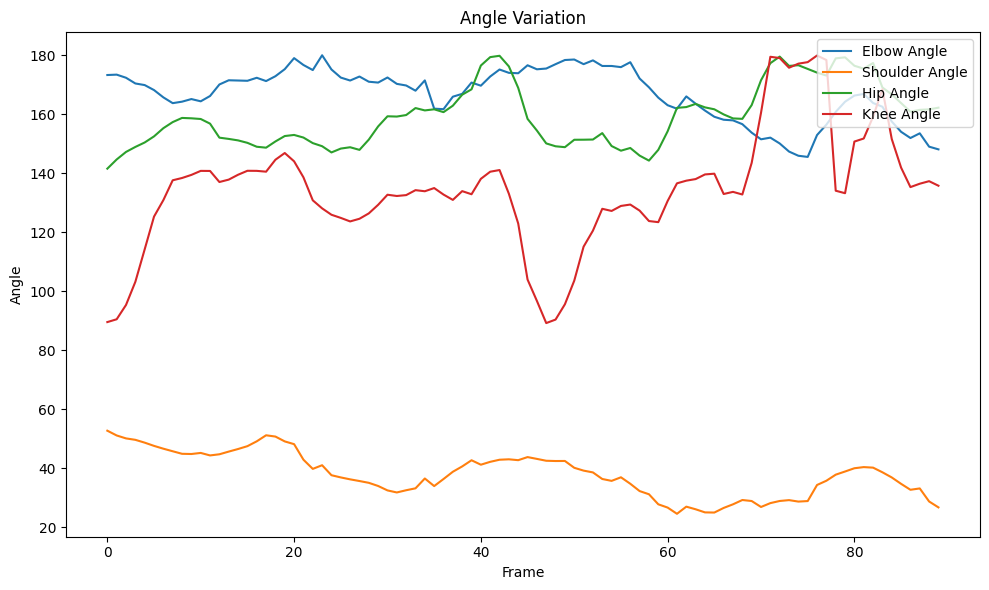

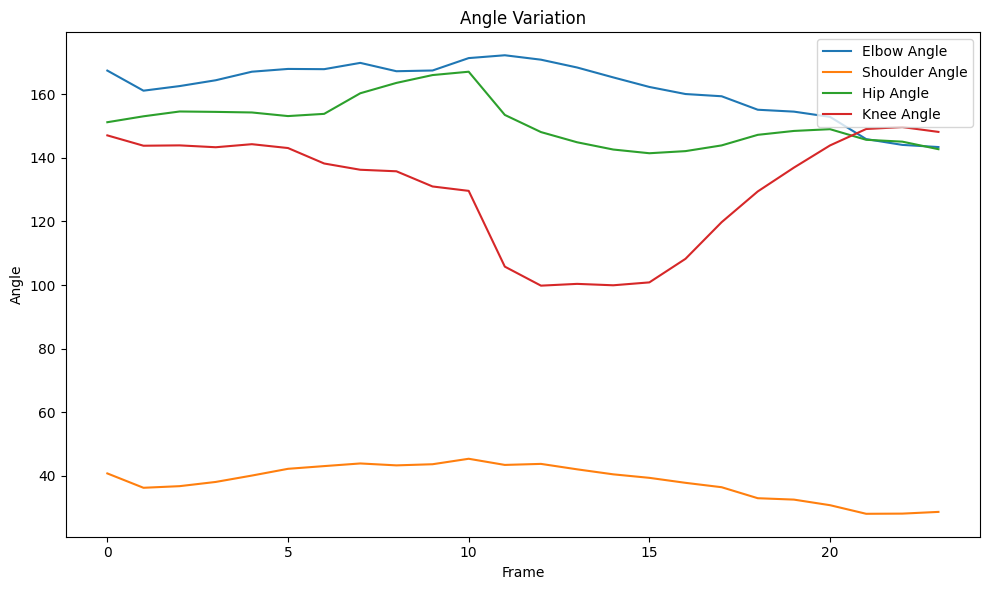

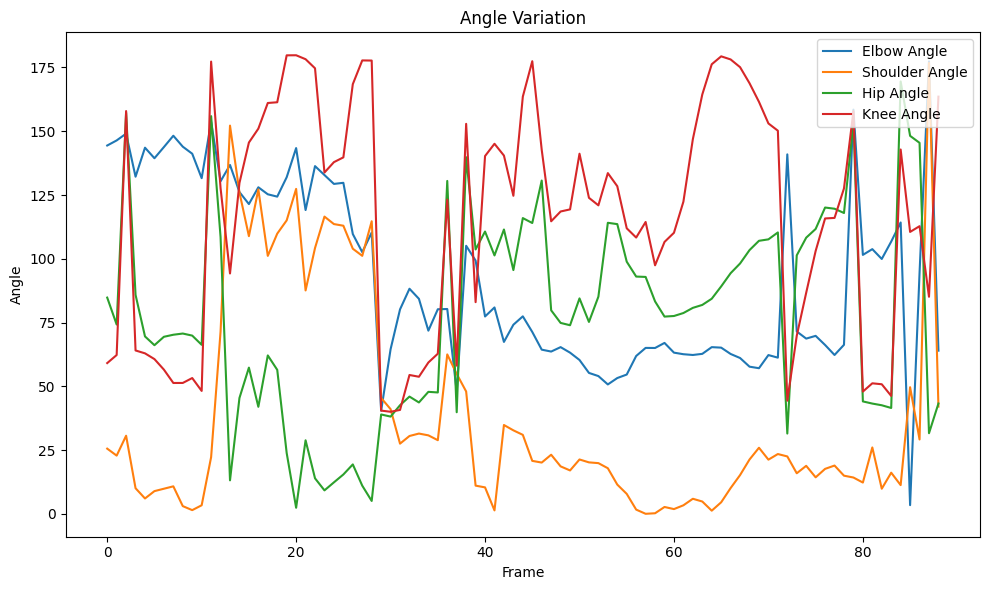

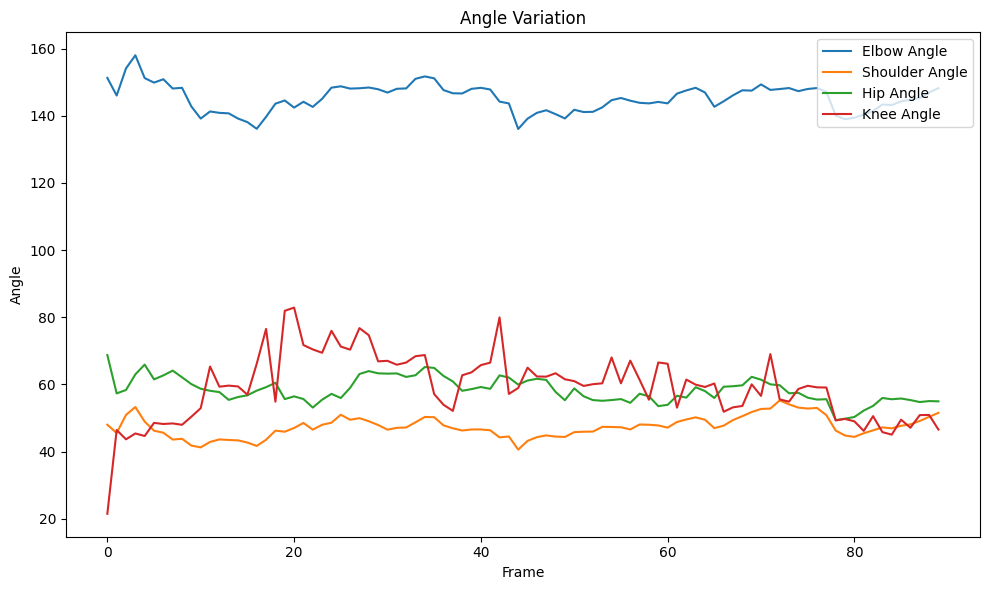

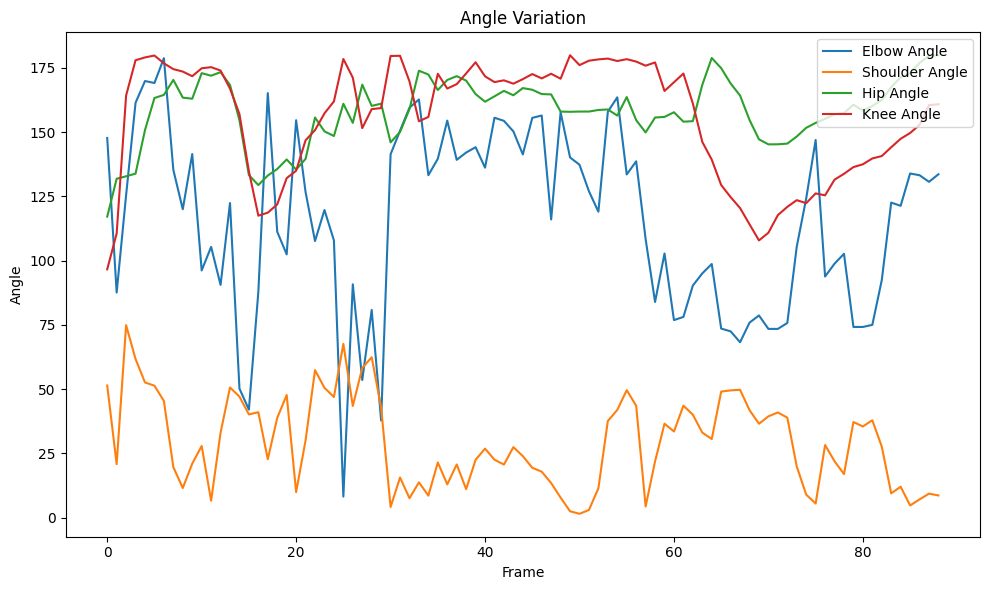

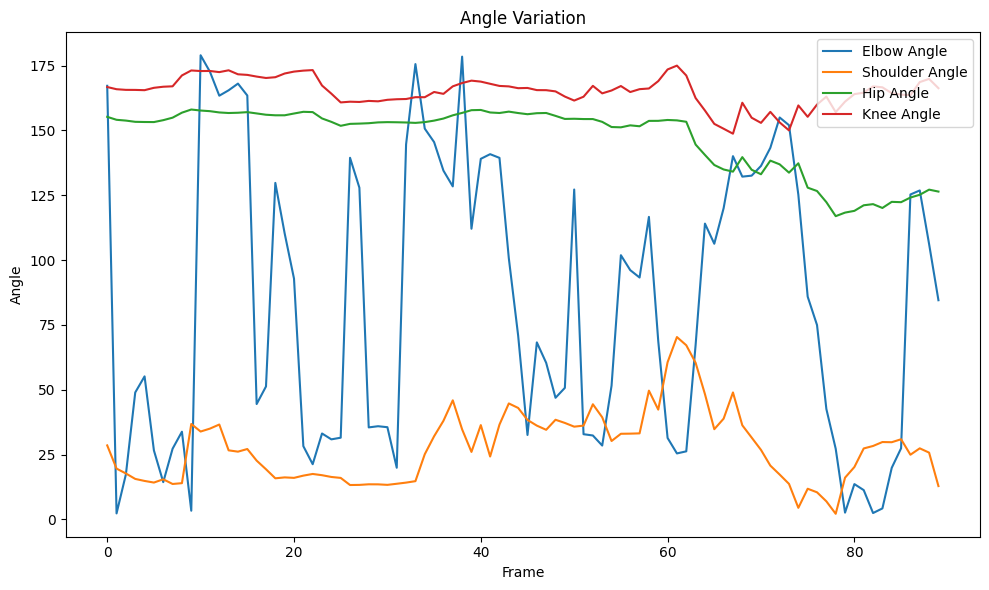

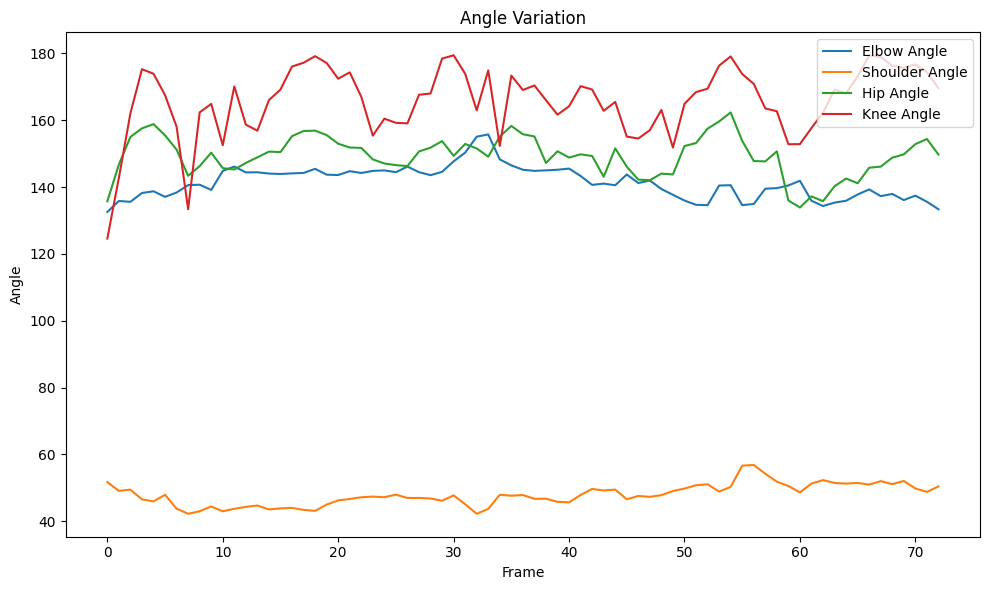

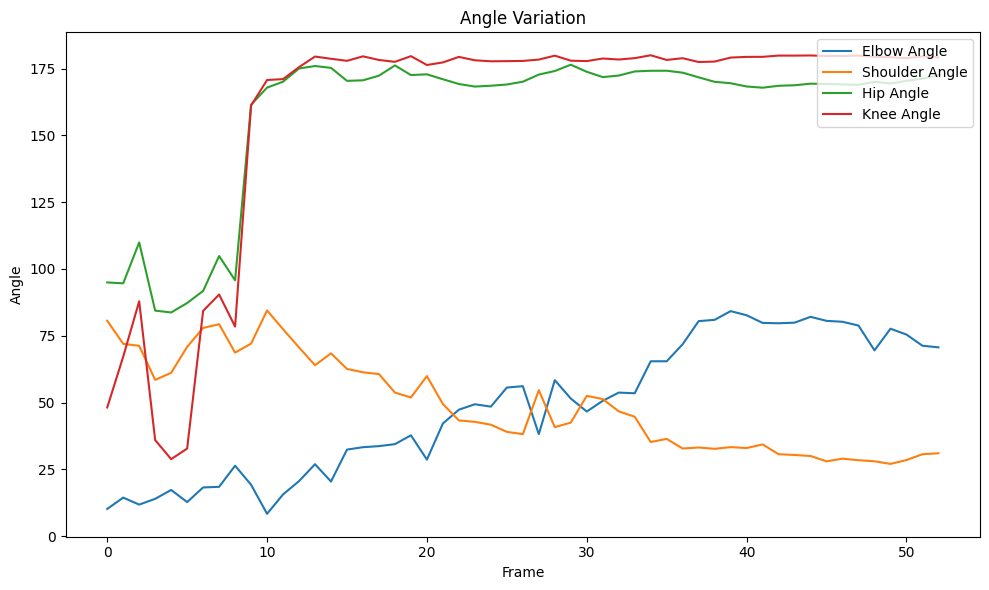

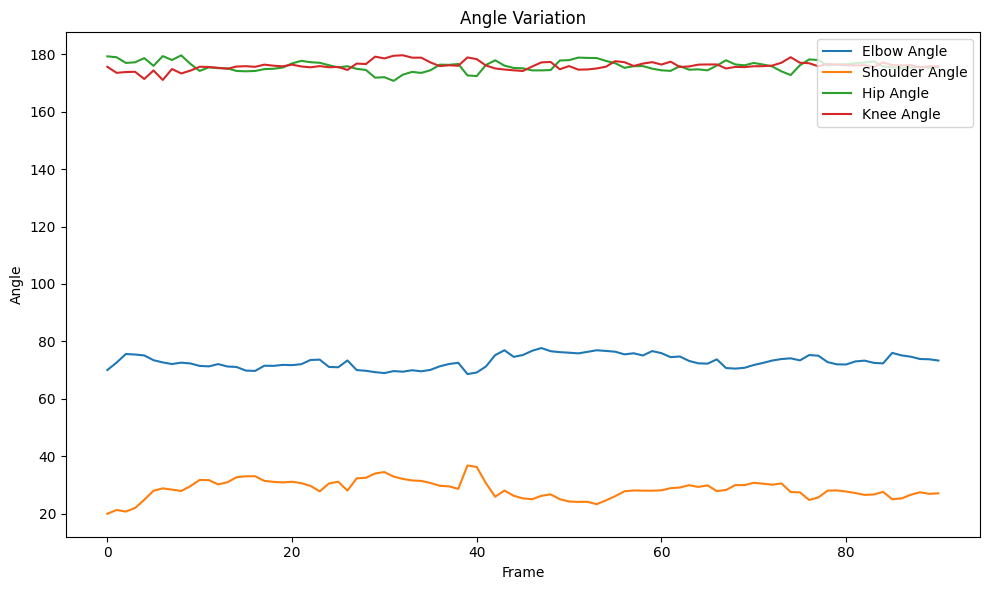

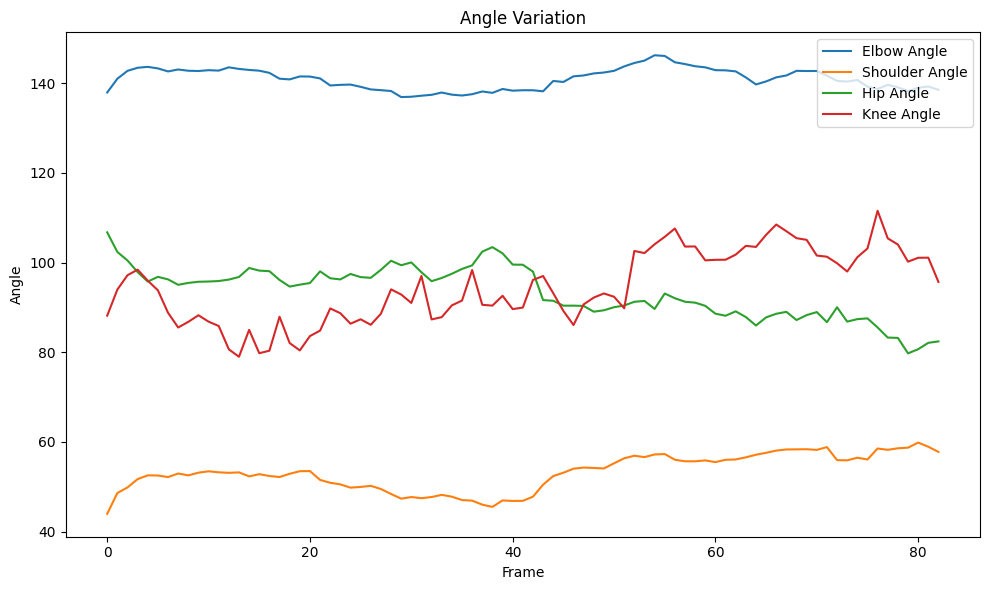

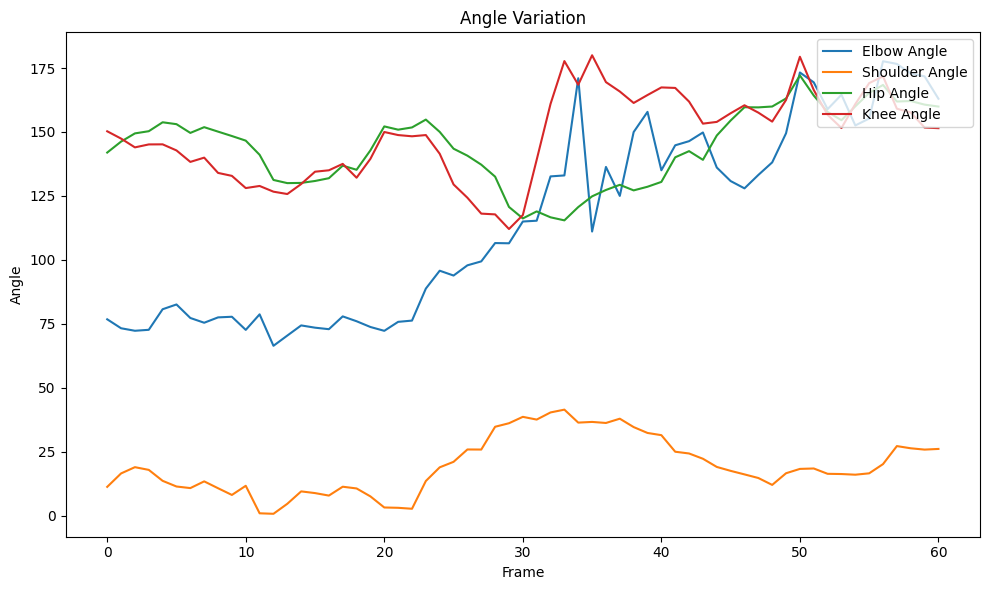

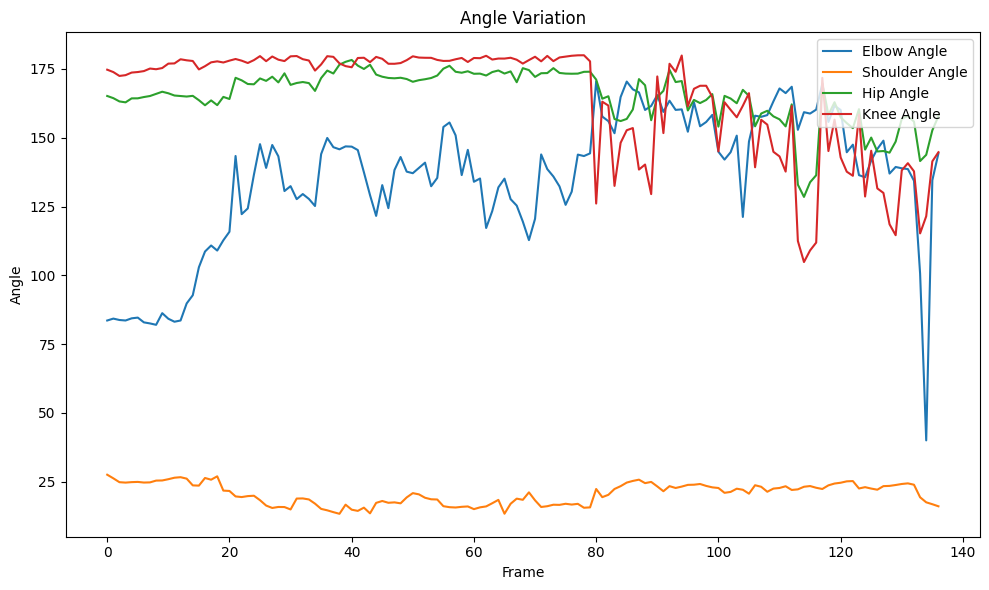

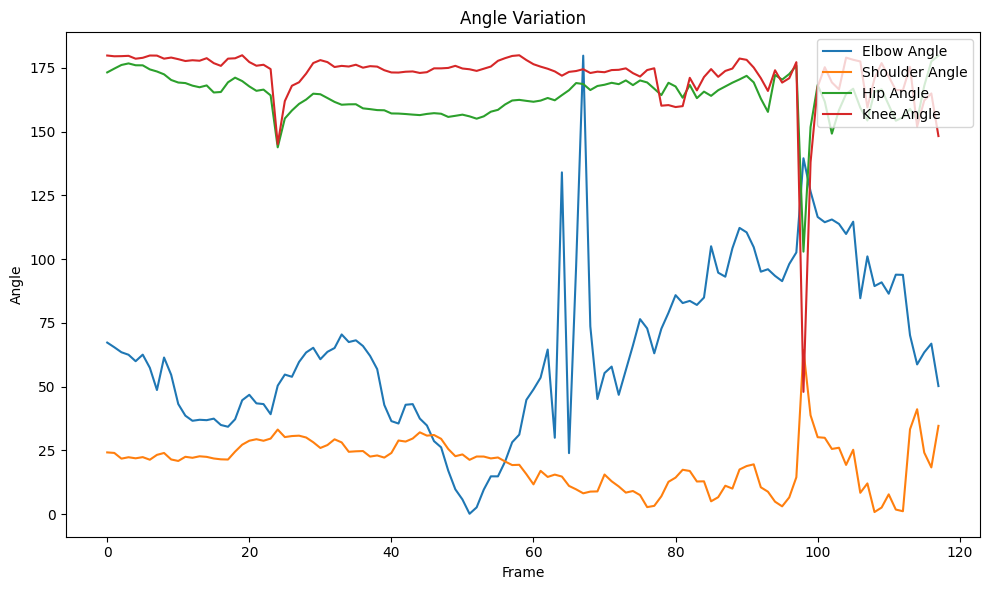

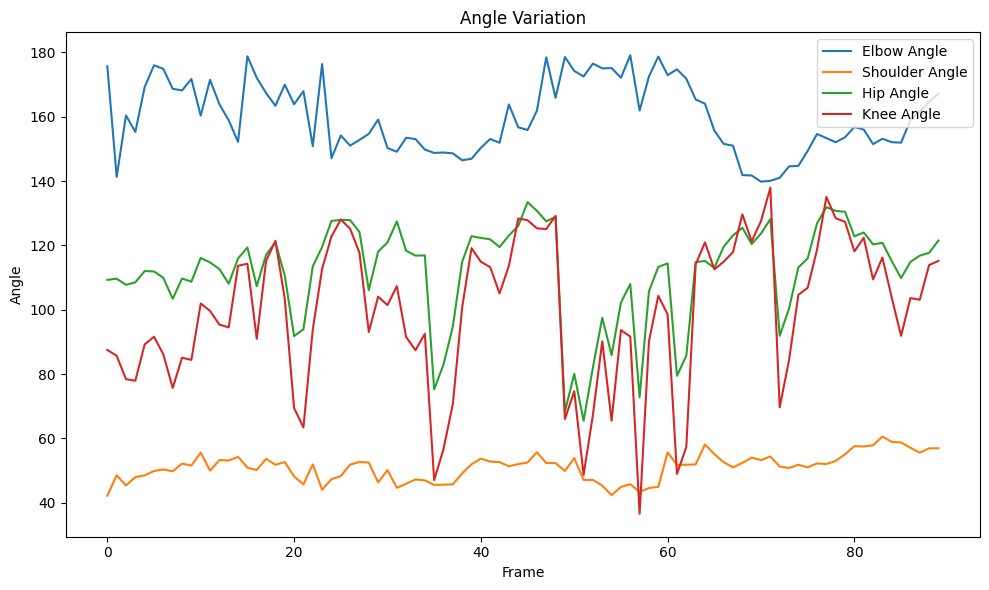

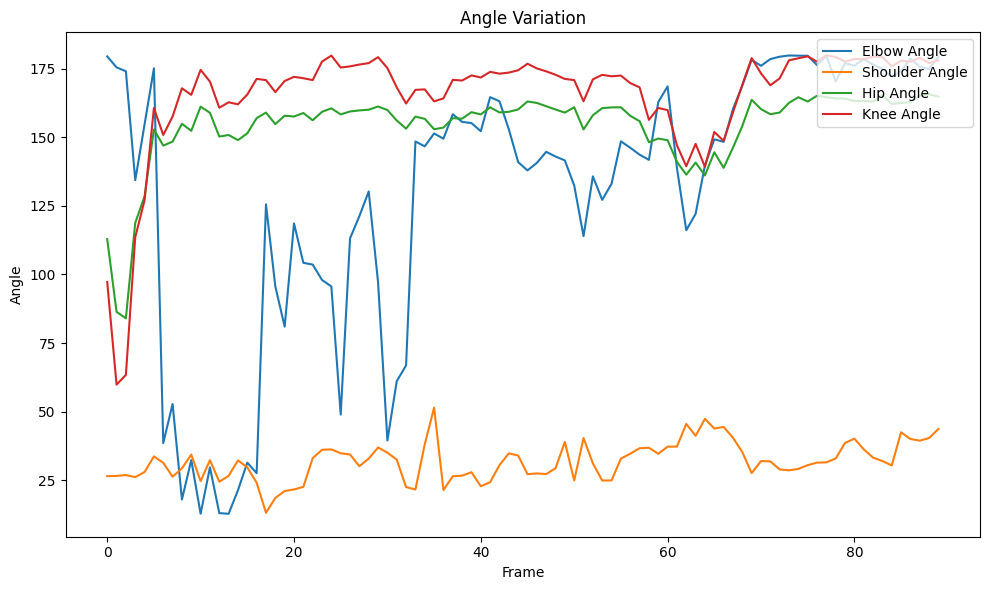

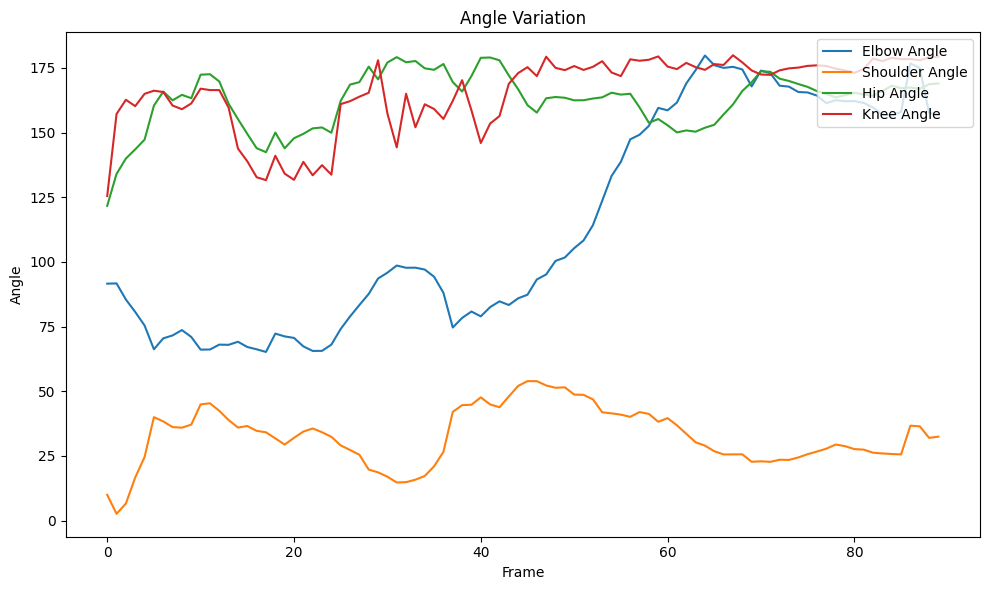

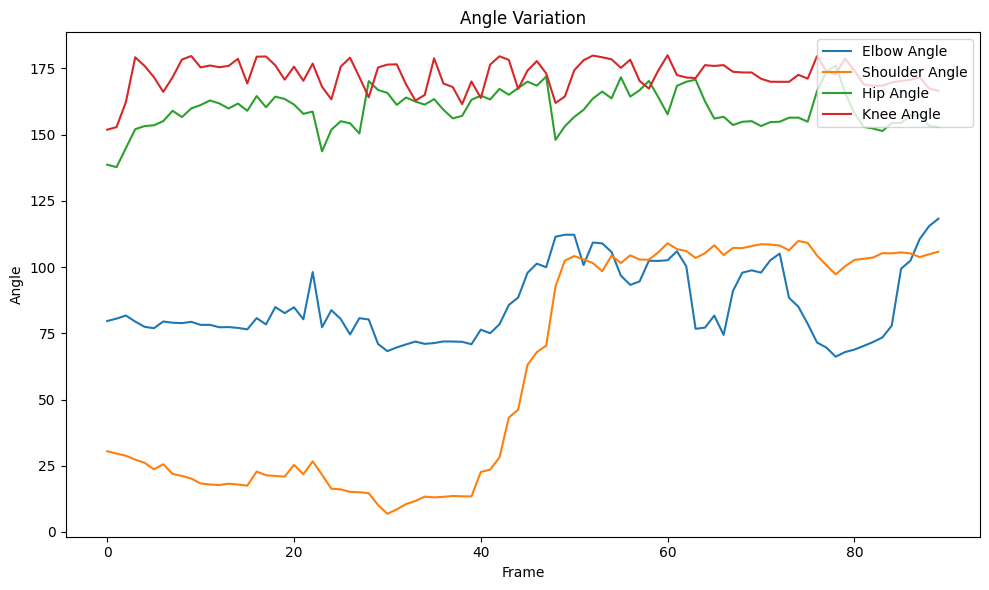

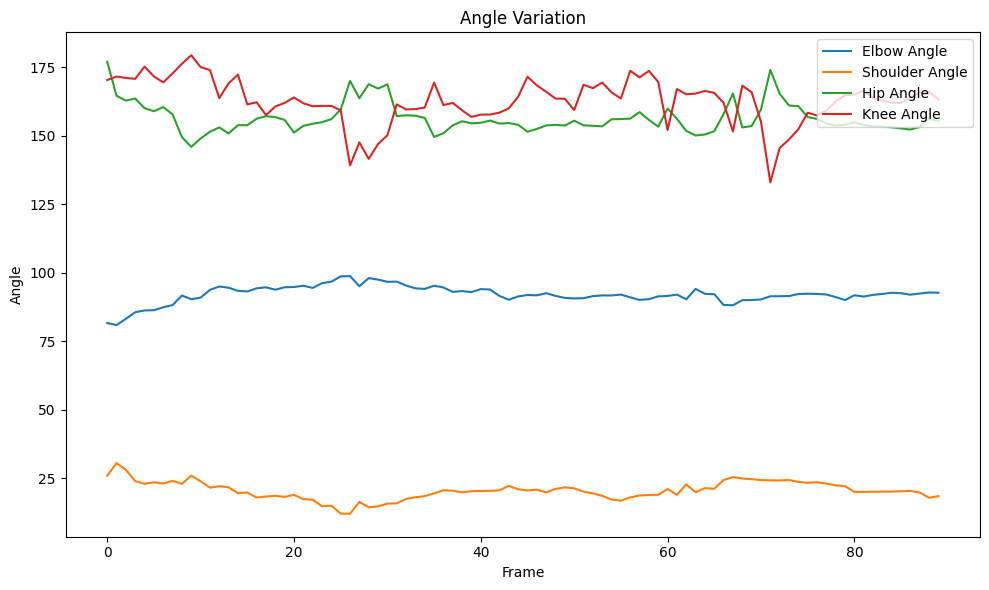

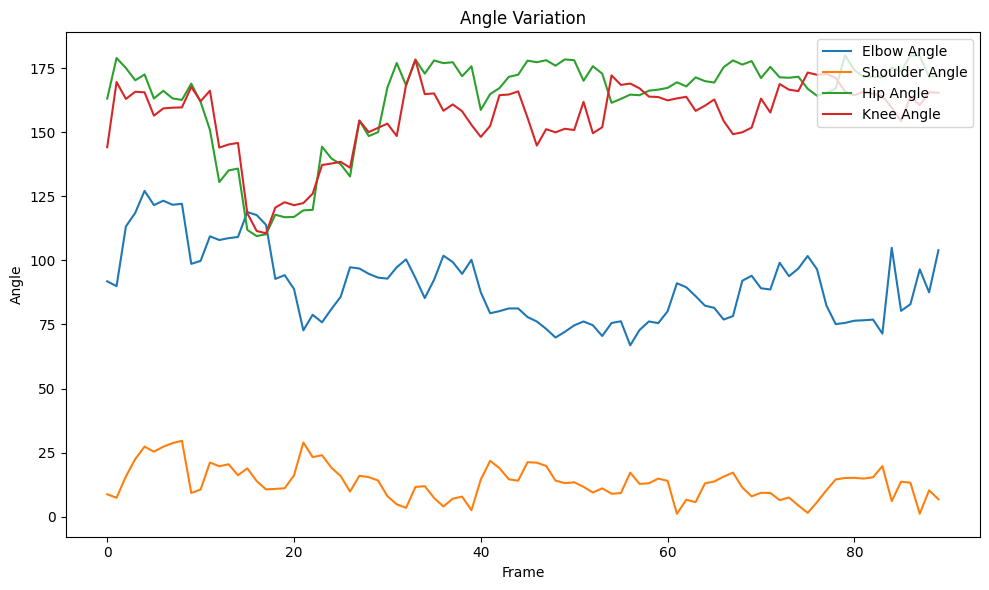

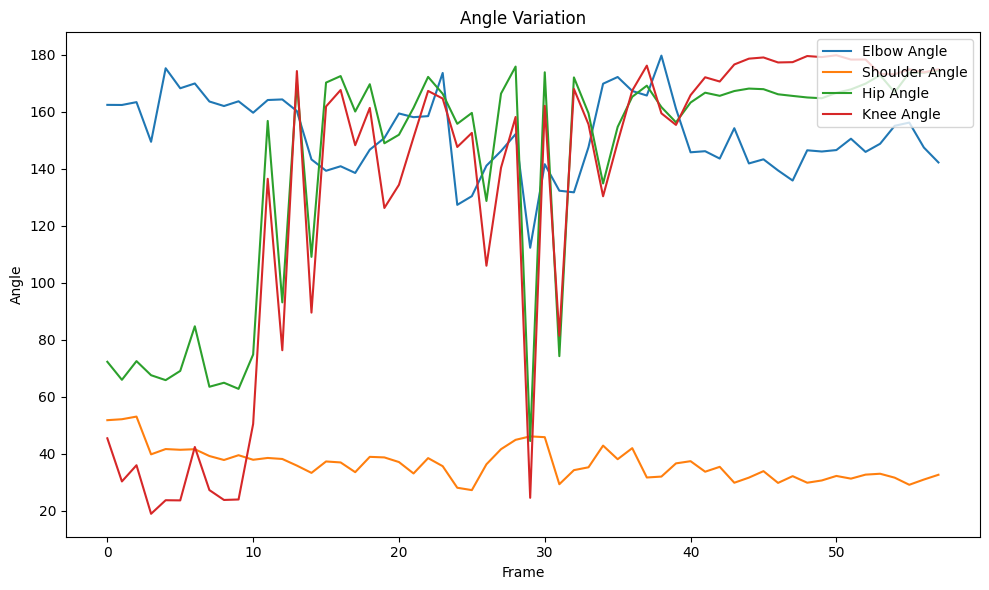

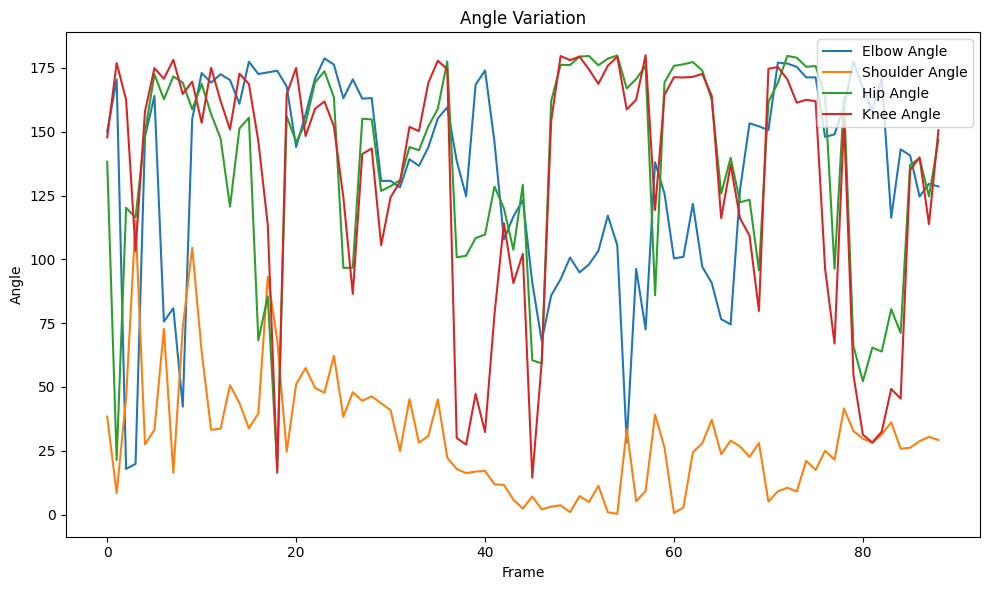

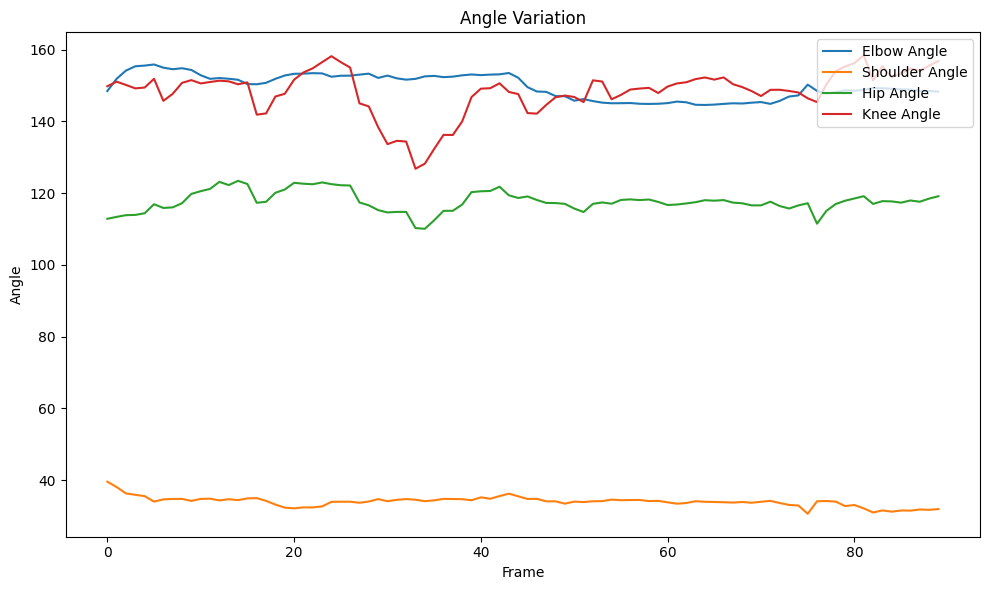

In [4]:
import pandas as pd
import cv2
import mediapipe as mp
import numpy as np
import os
import matplotlib.pyplot as plt
input_dir="C:\pukyung_202301\yolov7-object-cropping\input_video\crop"
image_dirs=os.listdir(input_dir)
for image_dir in image_dirs:
    direc = "C:\pukyung_202301\yolov7-object-cropping\input_video\crop"+"\\"+image_dir
    image_files = os.listdir(direc)
    image_files = sorted(image_files,key=lambda x:int(x.split('_')[1].split('.')[0]))
    #print(image_files)

    
    # Setup mediapipe instance
    # 신뢰도를 조절하며 그래프를 확인하기
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        angle_elbow_list = []
        angle_shoulder_list = []
        angle_hip_list = []
        angle_knee_list = []

        for image_file in image_files:
            image_path = os.path.join(direc, image_file)
            #print(image_path)
            frame = cv2.imread(image_path)

            # Recolor image to RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False
            # Make detection
            results = pose.process(image)

            # Recolor back to BGR
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Extract landmarks
            try:
                landmarks = results.pose_landmarks.landmark

                # Get coordinates
                shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
                ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,
                         landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]
                knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,
                        landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
                hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,
                       landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]

                # Calculate angles
                angle_elbow = calculate_angle(shoulder, elbow, wrist)
                angle_shoulder = calculate_angle(hip, shoulder, elbow)
                angle_hip = calculate_angle(knee, hip, shoulder)
                angle_knee = calculate_angle(ankle, knee, hip)

                # Append angles to the lists
                angle_elbow_list.append(angle_elbow)
                angle_shoulder_list.append(angle_shoulder)
                angle_hip_list.append(angle_hip)
                angle_knee_list.append(angle_knee)

                # Visualize angles
                cv2.putText(image, str(angle_elbow),
                            tuple(np.multiply(elbow, [image.shape[1], image.shape[0]]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
                cv2.putText(image, str(angle_shoulder),
                            tuple(np.multiply(shoulder, [image.shape[1], image.shape[0]]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
                cv2.putText(image, str(angle_hip),
                            tuple(np.multiply(hip, [image.shape[1], image.shape[0]]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
                cv2.putText(image, str(angle_knee),
                            tuple(np.multiply(knee, [image.shape[1], image.shape[0]]).astype(int)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA)
            except:
                pass

            # Render detections
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                      mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2),
                                      mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

            # Save annotated image
            output_file = os.path.join(output_dir, "annotated_" + image_file)
            cv2.imwrite(output_file, image)

            cv2.imshow('Pose Estimation', image)
            key = cv2.waitKey(1)  # Delay in milliseconds (2 seconds here)
            if key == ord('q'):
                break

        # Plot angle graphs
        plt.figure(figsize=(10, 6))
        plt.plot(angle_elbow_list, label='Elbow Angle')
        plt.plot(angle_shoulder_list, label='Shoulder Angle')
        plt.plot(angle_hip_list, label='Hip Angle')
        plt.plot(angle_knee_list, label='Knee Angle')
        plt.xlabel('Frame')
        plt.ylabel('Angle')
        plt.title('Angle Variation')
        plt.legend(loc=1)
        #plt.savefig('C:\pukyung_202301\yolov7-object-cropping\input_video\crop')
        plt.tight_layout()
        #plt.show()
        plt.savefig(direc)
        if len(angle_elbow_list)==0:
            continue
        print(len(angle_elbow_list),
              len(angle_hip_list),
              len(angle_knee_list),
              len(angle_shoulder_list))
        
        df = pd.DataFrame({'elbow':angle_elbow_list,
                 'shoulder':angle_shoulder_list,
                 'hip':angle_hip_list,
                 'knee':angle_knee_list})
        df.to_csv(direc+".csv")
        
        
    cv2.destroyAllWindows()